In [1]:
!pip install kaggle



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install tensorflow opencv-python matplotlib numpy seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Define the paths to the dataset folders
base_dir = './chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [6]:
# Set up image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

In [7]:
# Use ImageDataGenerator to preprocess and augment the data
# This step is crucial for increasing the size of your training data and improving model generalization.
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to a range of [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255) # Only normalize for test/validation data

In [8]:
# Load images from directories and create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary' # 'binary' since we have two classes: 'NORMAL' and 'PNEUMONIA'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False # Do not shuffle test data to maintain order for evaluation metrics
)

print("\n--- Data Preprocessing and Augmentation Complete ---")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

--- Data Preprocessing and Augmentation Complete ---


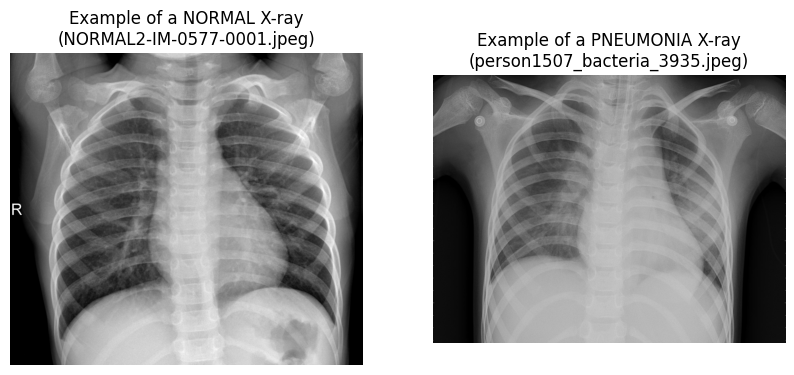


 Data Visualization


In [11]:
import os
import matplotlib.pyplot as plt
import random

# Define the paths to the dataset folders
base_dir = './chest_xray'
train_dir = os.path.join(base_dir, 'train')

# Get a random image file path from the 'NORMAL' folder
normal_dir = os.path.join(train_dir, 'NORMAL')
normal_files = os.listdir(normal_dir)
random_normal_img_path = os.path.join(normal_dir, random.choice(normal_files))

# Get a random image file path from the 'PNEUMONIA' folder
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
pneumonia_files = os.listdir(pneumonia_dir)
random_pneumonia_img_path = os.path.join(pneumonia_dir, random.choice(pneumonia_files))

# Read the random images
normal_img = plt.imread(random_normal_img_path)
pneumonia_img = plt.imread(random_pneumonia_img_path)

# You can keep your existing code for visualizing the batch of images
# ... (your previous code here) ...

# Plot the two random images side by side
plt.figure(figsize=(10, 5))

# Display the Normal X-ray
plt.subplot(1, 2, 1)
plt.imshow(normal_img, cmap='gray')
plt.title(f'Example of a NORMAL X-ray\n({os.path.basename(random_normal_img_path)})')
plt.axis('off')

# Display the Pneumonia X-ray
plt.subplot(1, 2, 2)
plt.imshow(pneumonia_img, cmap='gray')
plt.title(f'Example of a PNEUMONIA X-ray\n({os.path.basename(random_pneumonia_img_path)})')
plt.axis('off')

plt.show()

print("\n Data Visualization")

In [12]:
# Part 2: Model Building
# Here, we build a Convolutional Neural Network (CNN) architecture.

# Create a Sequential model
model = Sequential()

# Add Convolutional and Pooling Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten the output from the convolutional layers to feed into the dense layers
model.add(Flatten())

# Add Dense (fully-connected) Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Dropout layer to prevent overfitting
model.add(Dense(1, activation='sigmoid')) # Sigmoid activation for binary classification


C:\Users\Anwesa Bharasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compile the model
# Using the Adam optimizer and binary crossentropy as the loss function
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
# Display the model summary
model.summary()

print("\n--- Model Building Complete ---")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)


--- Model Building Complete ---


In [16]:
# Part 3: Model Training
# Train the model on the preprocessed data.
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,  # You can adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

print("\n--- Model Training Complete ---")

C:\Users\Anwesa Bharasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7906 - loss: 0.4631 - val_accuracy: 0.6250 - val_loss: 1.0828
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 770ms/step - accuracy: 0.8873 - loss: 0.2692 - val_accuracy: 0.8750 - val_loss: 0.4155
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 730ms/step - accuracy: 0.9045 - loss: 0.2240 - val_accuracy: 0.7500 - val_loss: 0.6480
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 682ms/step - accuracy: 0.9210 - loss: 0.2036 - val_accuracy: 0.6875 - val_loss: 0.5535
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9302 - loss: 0.1747 - val_accuracy: 0.6875 - val_loss: 0.9206
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 684ms/step - accuracy: 0.9321 - loss: 0.1742 - val_accuracy: 0.6250 - val_loss: 1.0297
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 667ms/step - accuracy: 0.9408 - loss: 0.1534 - val_accuracy: 0.6250 - val_loss: 1.0334
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 2804s 17s/step - accuracy: 0.9392 - los

In [27]:
# Part 4: Model Evaluation
# Evaluate the trained model on the test data.

# Get test predictions and true labels
y_pred_proba = model.predict(test_generator)
y_pred = (y_pred_proba > 0.5).astype("int32")
y_true = test_generator.classes

print("\n--- Evaluation Metrics ---")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step

--- Evaluation Metrics ---


              precision    recall  f1-score   support

      NORMAL       0.98      0.67      0.80       234
   PNEUMONIA       0.83      0.99      0.91       390

    accuracy                           0.87       624
   macro avg       0.91      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624



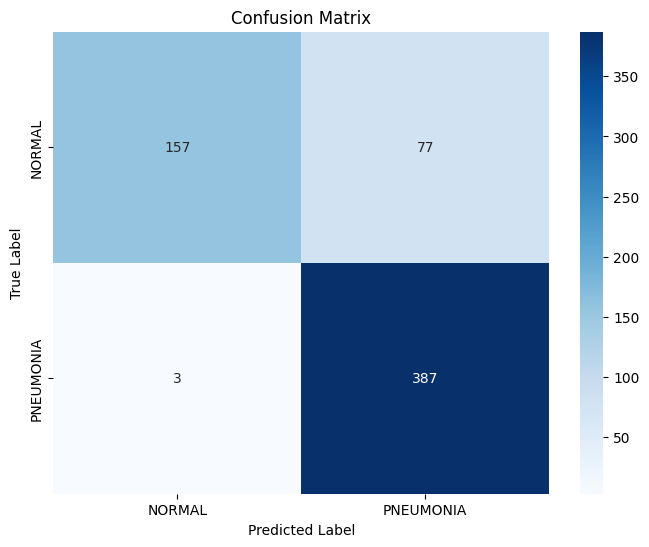

In [28]:
# Generate a classification report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [31]:
# Save the trained model to a file
model.save('pneumonia_detection_model.keras')
print("Model saved to 'pneumonia_detection_model.keras'")

Model saved to 'pneumonia_detection_model.keras'


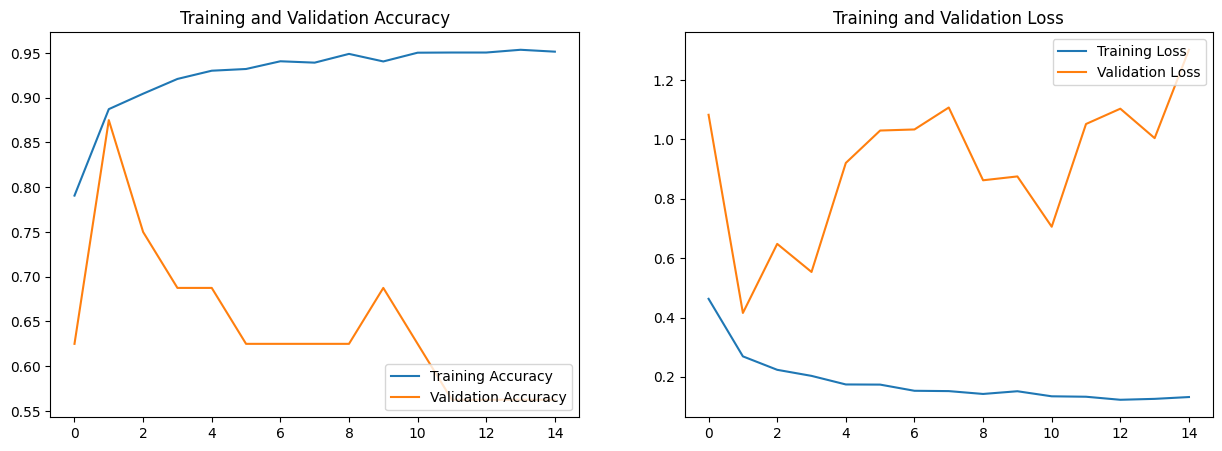


--- Model Evaluation Complete ---


In [29]:
# Plot training and validation accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("\n--- Model Evaluation Complete ---")

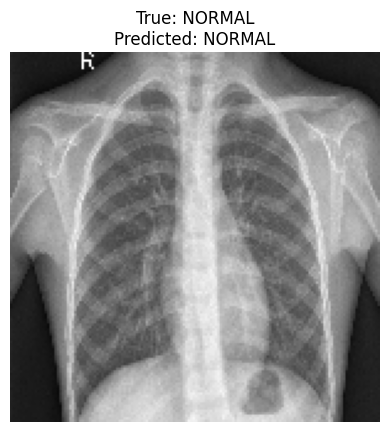

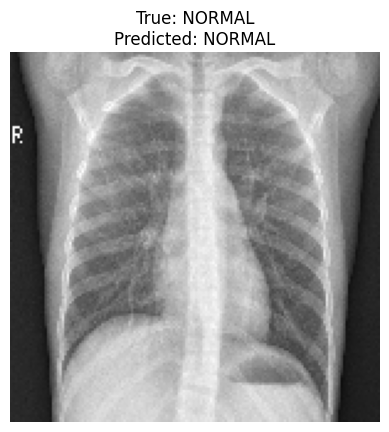

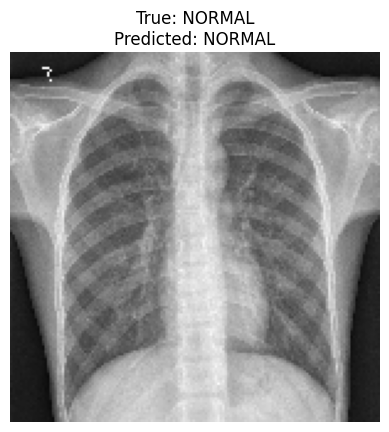

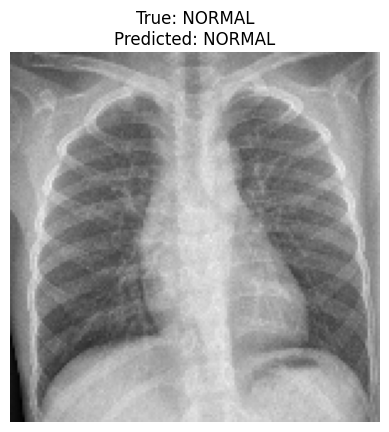

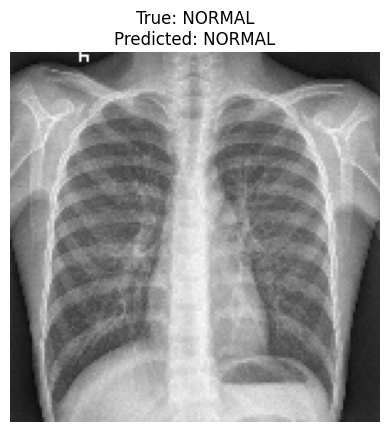

In [30]:
# Part 5: Findings and Interpretation
# Manually inspect some predictions to interpret the results.
# You can change the index to see different images.
x, y = next(test_generator)
for i in range(5):
    image = x[i]
    true_label = 'PNEUMONIA' if y[i] == 1 else 'NORMAL'
    predicted_label = 'PNEUMONIA' if y_pred[i] == 1 else 'NORMAL'
    plt.imshow(image)
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')
    plt.show()